In [1]:
import sys
sys.path.append("..")

import warnings
from pathlib import Path

import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.linalg as npl
import math
import random

from sklearn.covariance import GraphicalLassoCV
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch

from nilearn import signal
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
from nilearn.connectome import GroupSparseCovariance, GroupSparseCovarianceCV

from bold_dementia.data.study import make_control_idx
from bold_dementia.data.memento import Memento, MementoTS
from bold_dementia.data.phenotypes import days_to_onset
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.matrices import plot_matrices


CACHE_DIR = "/georges/memento/BIDS/derivatives/schaeffer/"

confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}
SOFT = False
ATLAS = "schaeffer"

random.seed(1)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


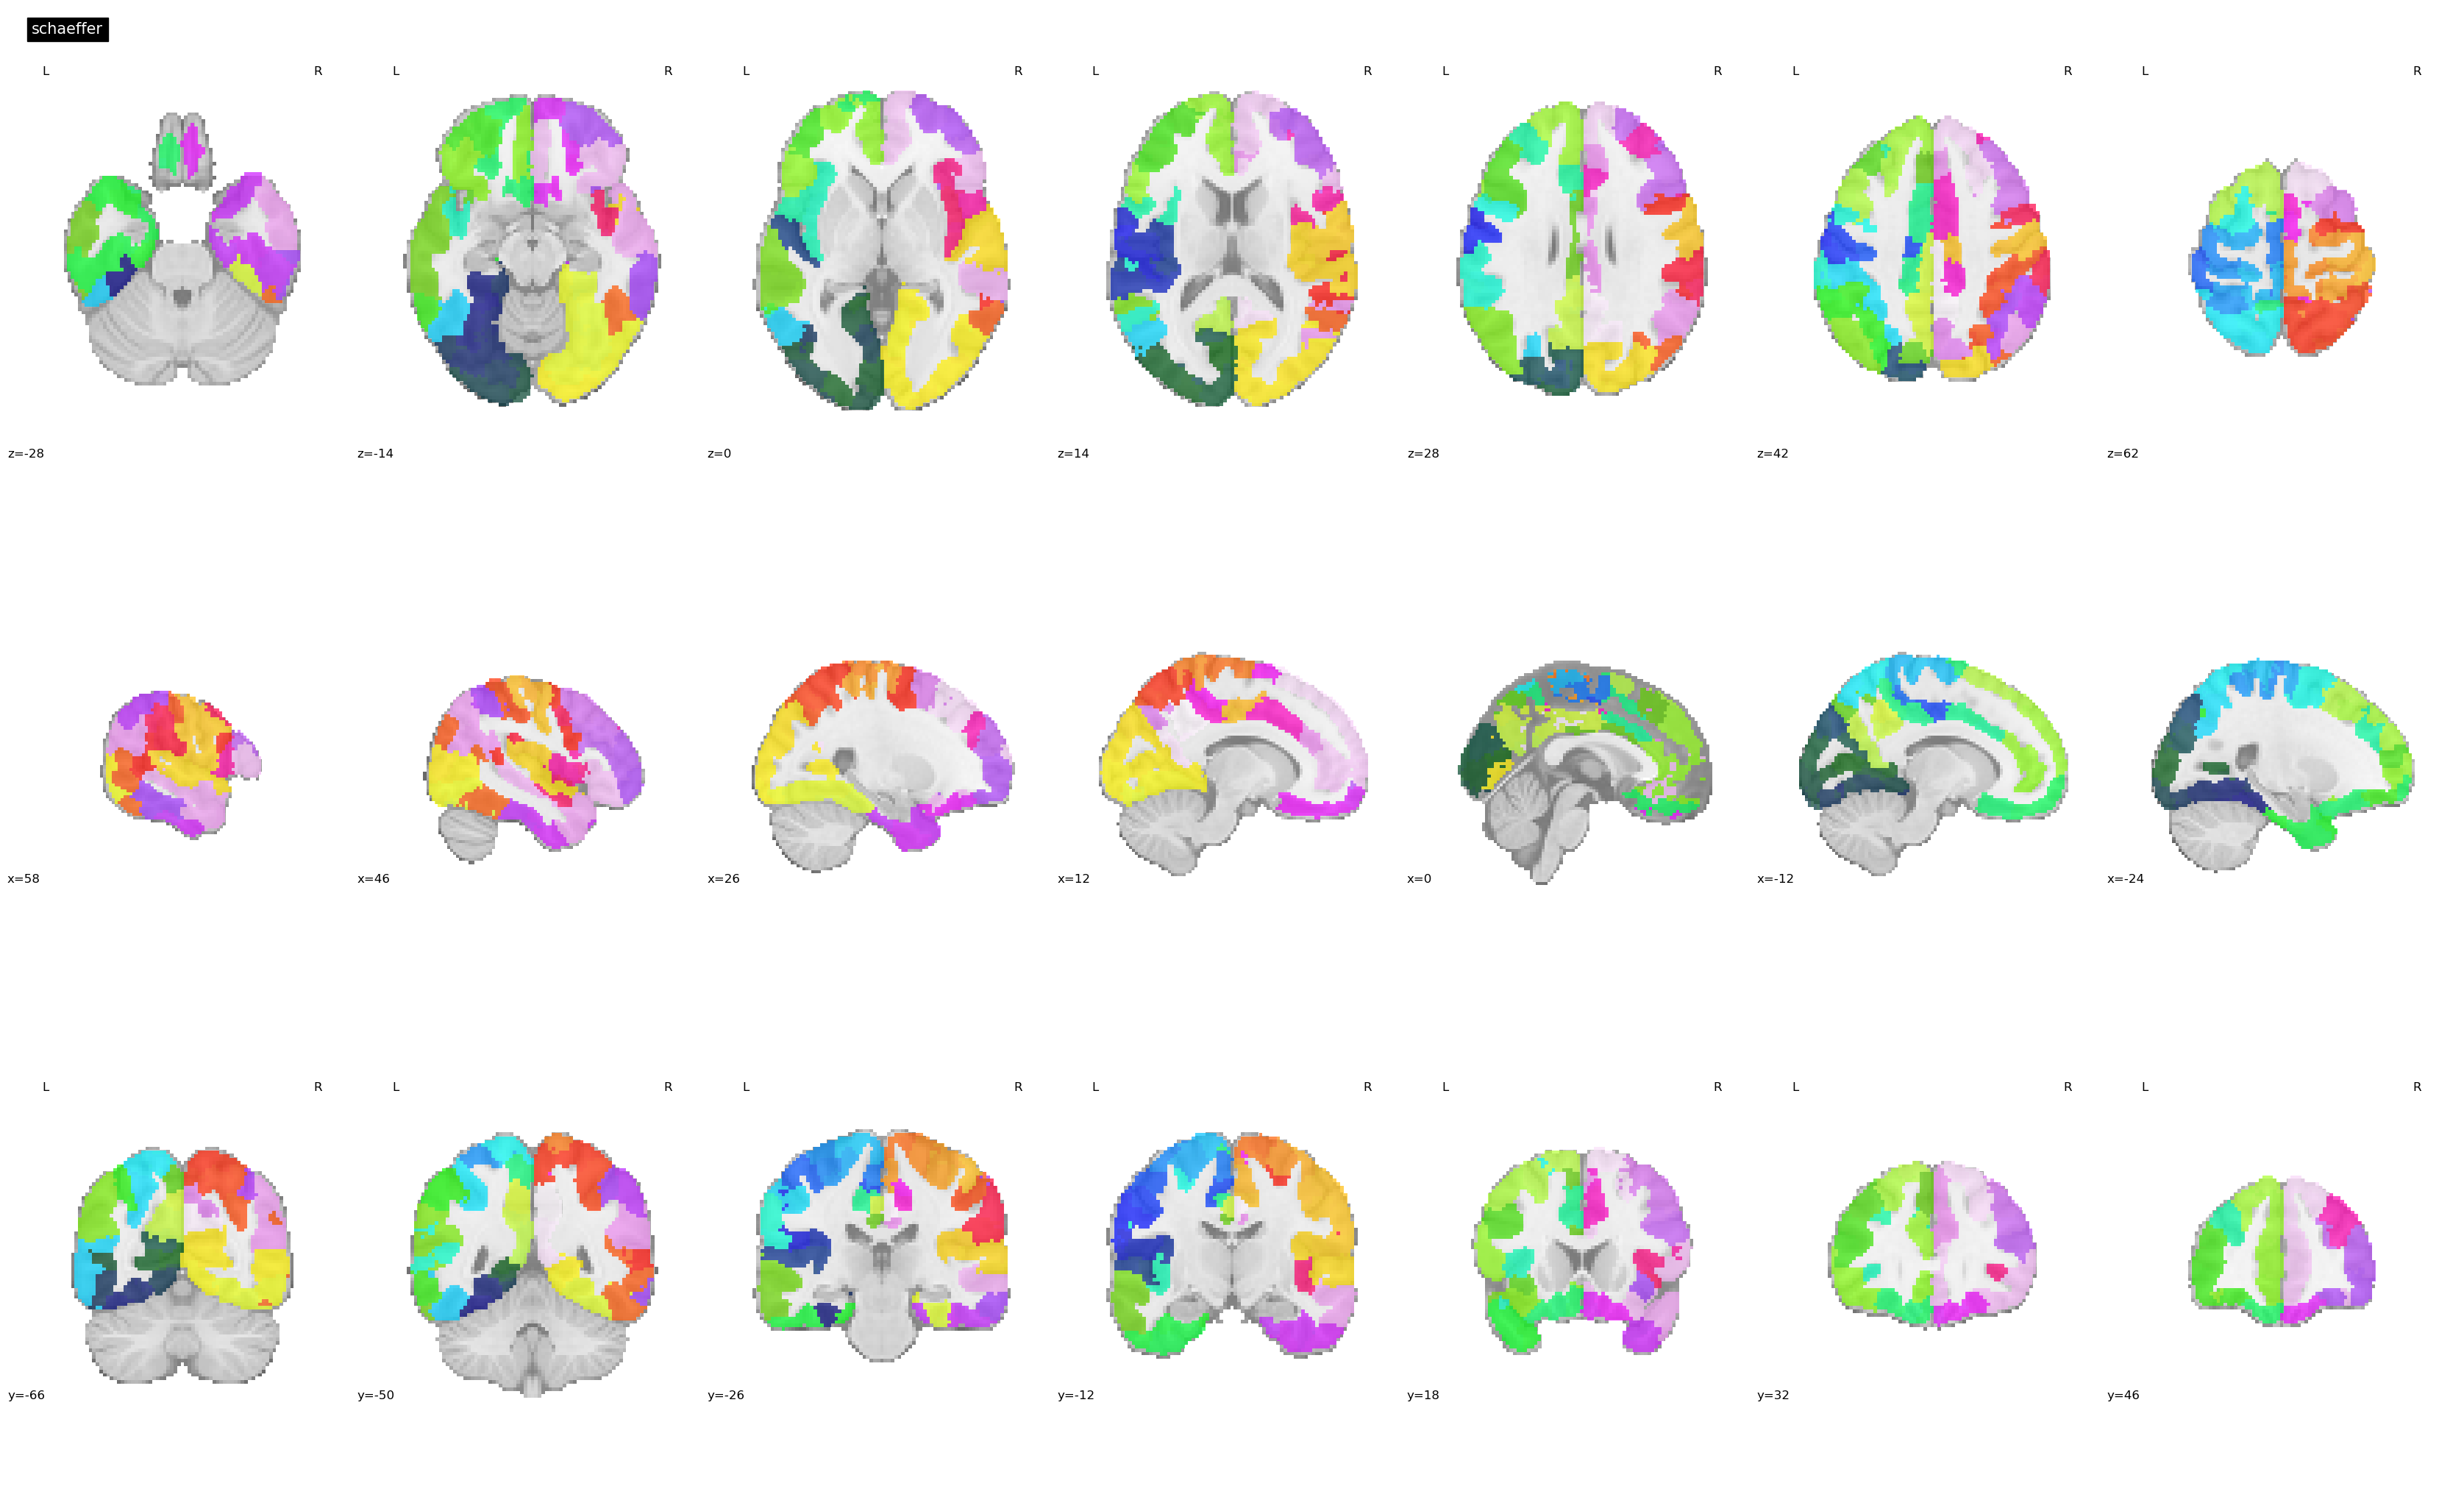

In [2]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
atlas.plot(display_mode="mosaic")
plotting.show()

In [3]:
def days_to_onset(row):
    return row.scan_to_onset

memento = MementoTS(cache_dir=CACHE_DIR, target_func=lambda row: row)

res = next(iter(memento))
res

(array([[662.8475 , 647.64514, 670.0993 , ..., 877.73083, 882.3985 ,
         913.4702 ],
        [658.8802 , 642.1198 , 660.2319 , ..., 871.4786 , 885.58026,
         910.0192 ],
        [656.66705, 643.5157 , 659.10895, ..., 869.2196 , 884.5311 ,
         900.2189 ],
        ...,
        [659.4836 , 647.7854 , 669.7048 , ..., 872.0773 , 886.2803 ,
         910.8693 ],
        [653.1279 , 647.9702 , 663.46655, ..., 867.3978 , 892.3242 ,
         912.53314],
        [654.3256 , 640.2316 , 662.6041 , ..., 869.99915, 888.7917 ,
         911.5599 ]], dtype=float32),
 file_path            /georges/memento/BIDS/derivatives/fmriprep-23....
 file_basename        sub-0001_ses-M000_task-rest_space-MNI152NLin6A...
 file_tag                                                          bold
 file_type                                                       nii.gz
 file_fields             ['sub', 'ses', 'task', 'space', 'res', 'desc']
 sub                                                                  

In [13]:
def load_signals(dataset, confounds_strategy, is_pos_func, is_neg_func):
    pos_ts = []
    neg_ts = []
    pos_meta = []
    neg_meta = []
    for ts, row, fpath in iter(dataset):
        confounds, sample_mask = load_confounds(
            fpath, **confounds_strategy
        )
        with warnings.catch_warnings(action="ignore", category=DeprecationWarning):
            cleaned_ts = signal.clean(
                ts,
                sample_mask=sample_mask,
                confounds=confounds,
                standardize="zscore_sample"
            )
        if is_pos_func(row):
            pos_ts.append(cleaned_ts)
            pos_meta.append(row)
        elif is_neg_func(row):
            neg_ts.append(cleaned_ts)
            neg_meta.append(row)

    pos_meta = pd.DataFrame(pos_meta).reset_index(drop=True)
    neg_meta = pd.DataFrame(neg_meta).reset_index(drop=True)
    return pos_ts, neg_ts, pos_meta, neg_meta
            
    

In [14]:
def balance_control(pos, control, col_name, tol=1):
    gap = pos[col_name].mean() - control[col_name].mean()
    # Usually the age is lower in control group
    while gap > tol:
        idx_to_drop = control[col_name].idxmin()
        print(control.loc[idx_to_drop, col_name], end=", new gap = ")
        control = control.drop(idx_to_drop)

        if len(control) <= len(pos):
            raise ValueError("Removed too many subjects from control")
        gap = pos[col_name].mean() - control[col_name].mean()
        print(gap)

    return pos, control
        

In [15]:
from bold_dementia.data.memento import past_diag

def healthy_control(row):
    return math.isnan(row.scan_to_onset)

AD_signals, control_signals, pm, nm = load_signals(memento, confounds_strategy, past_diag, healthy_control)

In [16]:
_, balanced_meta = balance_control(pm, nm, col_name="current_scan_age")
balanced_signals = [control_signals[idx] for idx in balanced_meta.index]

38.4972602739726, new gap = 4.757215701461149
40.439726027397256, new gap = 4.74136134139664
41.31780821917808, new gap = 4.725928902305043
42.41643835616438, new gap = 4.711029014464728
42.49178082191781, new gap = 4.696151852517644
43.37534246575343, new gap = 4.681700954834142
44.40273972602739, new gap = 4.667748806134114
44.48767123287672, new gap = 4.6538251567891535
44.59178082191781, new gap = 4.63993963858934
45.6, new gap = 4.62654458969503
46.25342465753425, new gap = 4.6134631717115155
46.37808219178083, new gap = 4.60043107505912
46.85479452054794, new gap = 4.587624754025711
47.04657534246575, new gap = 4.574901725312998
47.4, new gap = 4.562343179348602
47.638356164383566, new gap = 4.549891627399489
47.7, new gap = 4.537458519592818
47.8054794520548, new gap = 4.525065900604034
47.92876712328767, new gap = 4.512722780325419
48.3, new gap = 4.500553891638646
48.45205479452055, new gap = 4.48844924692429
48.69178082191781, new gap = 4.47645306559086
48.7, new gap = 4.4644

In [18]:
# Merge series but keep track of indices
time_series = AD_signals + balanced_signals
AD_indices = list(range(len(AD_signals)))
control_indices = list(range(len(AD_signals), len(time_series)))
n = len(time_series)
print(f"Study on {n} subjects")

Study on 1617 subjects


In [19]:
from sklearn import covariance
from bold_dementia.models.transformers import ListMixin, Concatenator
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator


# (if we can still use GroupSparseCovariance as estimator)
# Or maybe give Ledoit Wolf another chance

# The sample correlation matrix with relatively short time series
# is a bad estimate of functionnal connectivity

# TODO Add reorganisation layer to put in ConnectivityMeasure format
#pipe = Pipeline(
#    [
#        ("scaler", ListScaler()),
#        ("cov", GroupSparseCovariance(alpha=0.0011)), # alpha found by CV
#    ]
#)
pipe = ConnectivityMeasure(
    covariance.LedoitWolf(),
    kind="covariance")

# Fit AD and controls together to have a common sparsity pattern,
# but is that a good idea?
c = pipe.fit_transform(time_series)




In [20]:

# Use Bunch for compatibility with pipelines
gcov = Bunch(
    covariances_=c,
    precisions_=npl.inv(c) # I don't like this
)

In [21]:

#gcov = pipe.named_steps["cov"]
AD_cov = gcov.covariances_[AD_indices, :, :].mean(axis=0)
AD_prec = gcov.precisions_[AD_indices, :, :].mean(axis=0)

control_cov = gcov.covariances_[control_indices, :, :].mean(axis=0)
control_prec = gcov.precisions_[control_indices, :, :].mean(axis=0)

In [22]:

# TODO Macro labelling, should be added in atlases?
# TODO all those labels, refactor names
from matplotlib.ticker import FixedLocator

def plot_matrices(cov, prec, title, labels, macro_labels=True):
    """Plot covariance and precision matrices.
    For macro labels only schaeffer has been tested so far
    """
    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # We want network labels to span over several rows
    if macro_labels:
        networks = np.array(list(map(lambda x: str(x).split("_")[2], labels)))
        n_regions = len(labels)
        labels = None
        sort_index = np.argsort(networks)
        ticks = []
        lbls = []
        prev_label = None
        for i, label in enumerate(networks[sort_index]):
            if label != prev_label:
                ticks.append(i)
                lbls.append(label)
                prev_label = label
                ax1.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax2.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax1.vlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax2.vlines(i, 0, n_regions, colors="black", linestyles="dotted")

        ticks.append(i + 1)
        
    else:
        sort_index = np.arange(len(prec))

    sns.heatmap(cov[np.ix_(sort_index, sort_index)], ax=ax1, vmin=-1, vmax=1, cmap="seismic")
    sns.heatmap(prec[np.ix_(sort_index, sort_index)], ax=ax2, cmap="seismic", vmin=-span, vmax=span)

    # This is a bit unstatisfying
    if macro_labels:
        ax1.yaxis.set_minor_locator(FixedLocator(ticks))
        ax1.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax1.xaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax1.set_yticklabels(lbls, rotation=0)
        ax1.set_xticklabels(lbls, rotation=30)
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    return fig

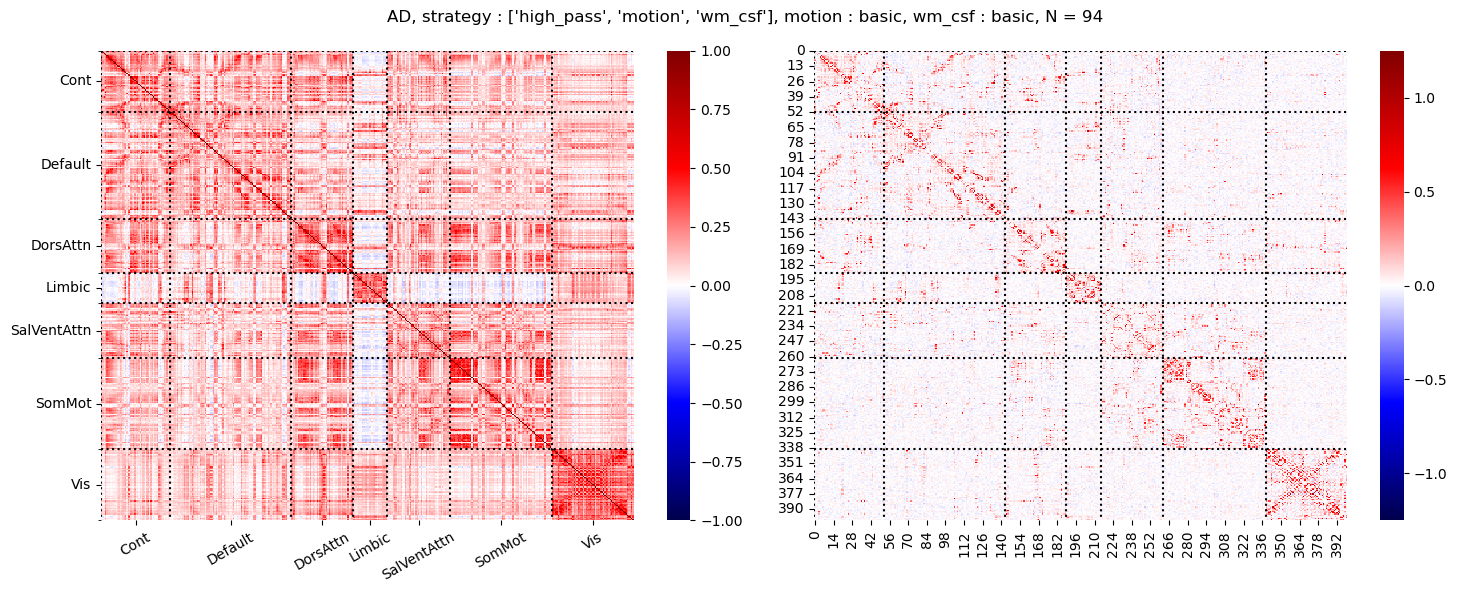

In [23]:
title = ", ".join([f"{k} : {v}" for k, v in confounds_strategy.items()])

# Mean ou pas mean?
plot_matrices(AD_cov, -AD_prec, f"AD, {title}, N = {len(AD_signals)}", atlas.labels, macro_labels=True)

plotting.show()

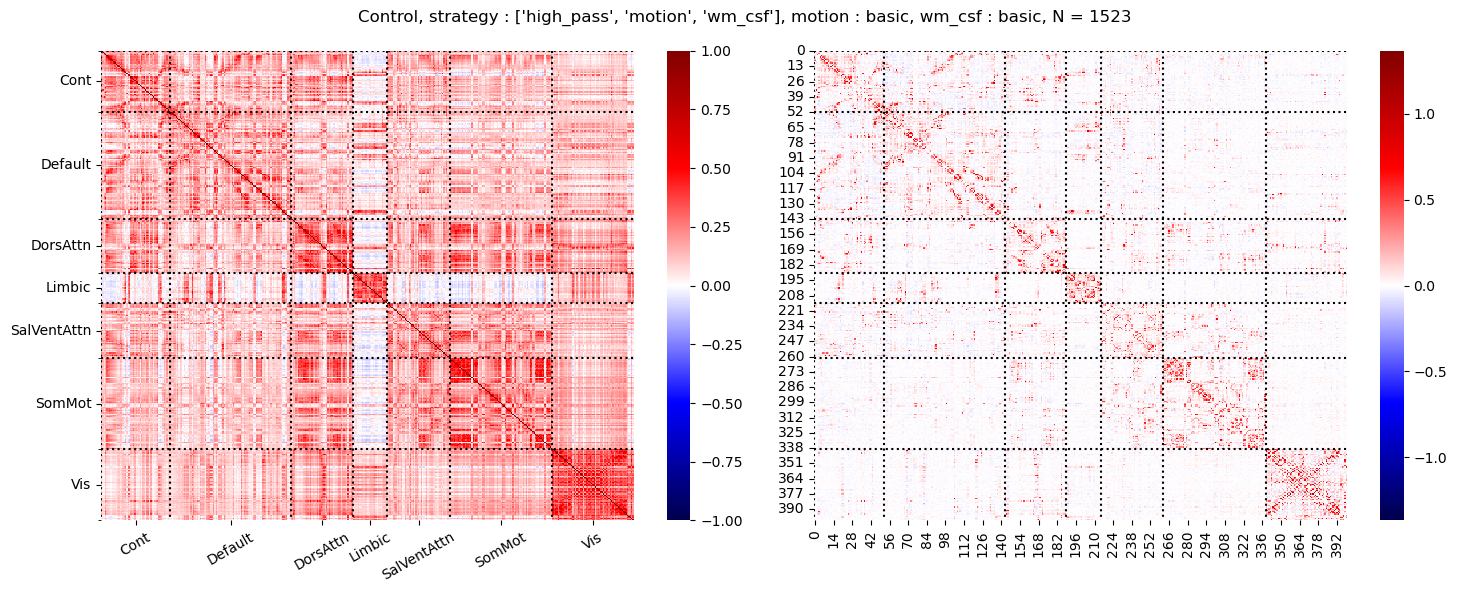

In [24]:
plot_matrices(control_cov, -control_prec, f"Control, {title}, N = {len(balanced_signals)}", atlas.labels, macro_labels=True)

plotting.show()

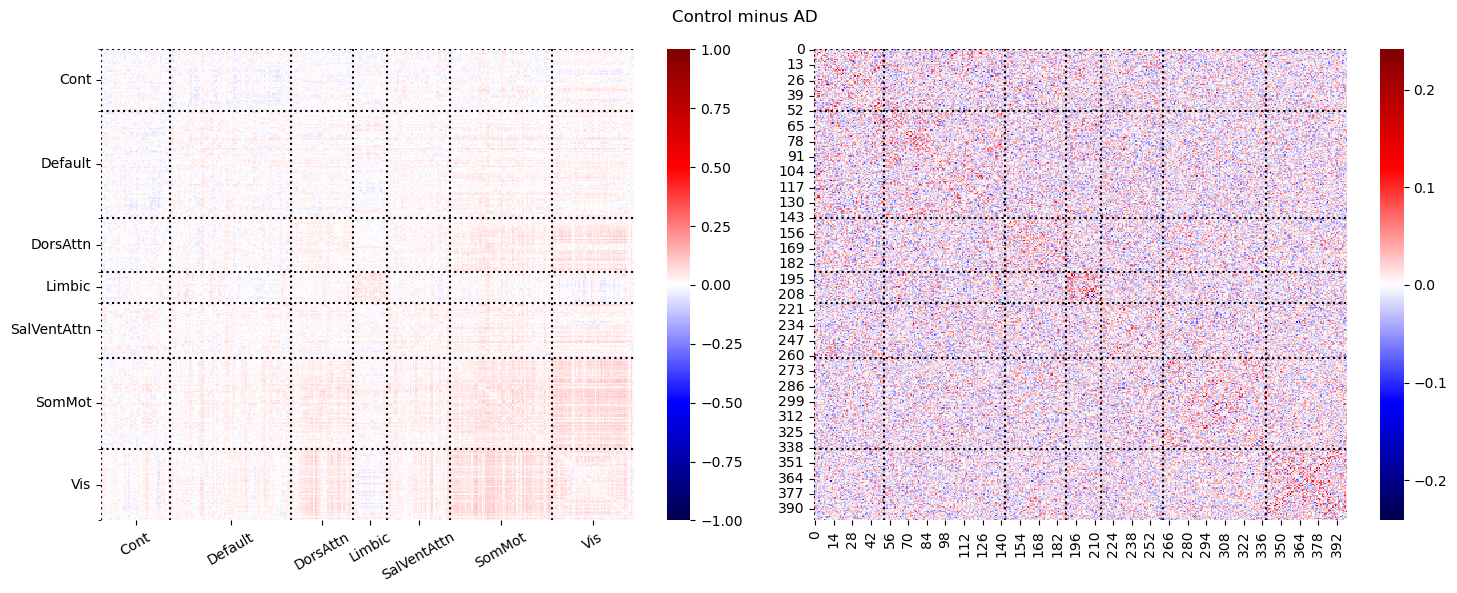

In [25]:
# TODO Same pipeline but shufle time series at the beginning to compare
# TODO Control for age?
plot_matrices(
    control_cov - AD_cov,
    -control_prec + AD_prec,
    "Control minus AD",
    atlas.labels,
    macro_labels=True
)
plotting.show()

In [ ]:
diff = control_cov - AD_cov
plt.hist(diff.flatten())
plt.show()

NameError: name 'control_cov' is not defined